In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [16]:
print("\n" + "="*80)
print("LOADING AMES HOUSING DATASET")
print("="*80)

# Load the dataset - make sure train.csv is in the same directory
try:
    data = pd.read_csv('train.csv')
    print(f"✓ Dataset loaded successfully!")
    print(f"✓ Dataset shape: {data.shape}")
    print(f"✓ Number of houses: {len(data):,}")
    
except FileNotFoundError:
    print("❌ train.csv file not found!")
    print("Please make sure you have downloaded train.csv from the Kaggle Ames Housing dataset")
    print("and placed it in the same directory as this notebook.")
    raise

# Display first few rows
print("\n📊 First 5 rows of the dataset:")
print(data.head())

# Check dataset info
print("\n📈 Dataset Info:")
print(f"Total columns: {len(data.columns)}")
print(f"Total rows: {len(data)}")



LOADING AMES HOUSING DATASET
✓ Dataset loaded successfully!
✓ Dataset shape: (1460, 81)
✓ Number of houses: 1,460

📊 First 5 rows of the dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRi

In [18]:
print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# Define our key features based on the data description
feature_mapping = {
    'GrLivArea': 'Square_Footage',      # Above grade living area square feet
    'BedroomAbvGr': 'Bedrooms',              # Bedrooms above grade  
    'FullBath': 'Full_Bathrooms',       # Full bathrooms above grade
    'HalfBath': 'Half_Bathrooms',       # Half bathrooms above grade
    'SalePrice': 'Sale_Price'           # Target variable
}

# Check if all required columns exist
required_cols = list(feature_mapping.keys())
missing_cols = [col for col in required_cols if col not in data.columns]

if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
    print("Available columns:", list(data.columns))
else:
    print("✓ All required columns found!")

# Select and rename our features
selected_data = data[required_cols].copy()
selected_data = selected_data.rename(columns=feature_mapping)

# Create total bathrooms feature (Full + Half*0.5)
selected_data['Total_Bathrooms'] = (selected_data['Full_Bathrooms'] + 
                                   selected_data['Half_Bathrooms'] * 0.5)

# Final feature set
final_features = ['Square_Footage', 'Bedrooms', 'Total_Bathrooms']
target = 'Sale_Price'

print(f"\n📋 Selected Features:")
for i, feature in enumerate(final_features + [target], 1):
    print(f"  {i}. {feature}")


DATA PREPARATION
✓ All required columns found!

📋 Selected Features:
  1. Square_Footage
  2. Bedrooms
  3. Total_Bathrooms
  4. Sale_Price


In [19]:
print("\n" + "="*80)
print("DATA QUALITY ANALYSIS")
print("="*80)

# Check for missing values
print("🔍 Missing Values Check:")
missing_info = []
for col in final_features + [target]:
    missing_count = selected_data[col].isnull().sum()
    missing_pct = (missing_count / len(selected_data)) * 100
    missing_info.append({
        'Column': col,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    })
    print(f"  {col}: {missing_count} missing ({missing_pct:.1f}%)")

# Remove rows with missing values
print(f"\n🧹 Data Cleaning:")
initial_rows = len(selected_data)
clean_data = selected_data[final_features + [target]].dropna()
final_rows = len(clean_data)
removed_rows = initial_rows - final_rows

print(f"  Initial rows: {initial_rows:,}")
print(f"  Final rows: {final_rows:,}")
print(f"  Removed rows: {removed_rows:,} ({(removed_rows/initial_rows)*100:.1f}%)")



DATA QUALITY ANALYSIS
🔍 Missing Values Check:
  Square_Footage: 0 missing (0.0%)
  Bedrooms: 0 missing (0.0%)
  Total_Bathrooms: 0 missing (0.0%)
  Sale_Price: 0 missing (0.0%)

🧹 Data Cleaning:
  Initial rows: 1,460
  Final rows: 1,460
  Removed rows: 0 (0.0%)



EXPLORATORY DATA ANALYSIS
📊 Descriptive Statistics:
       Square_Footage  Bedrooms  Total_Bathrooms  Sale_Price
count         1460.00   1460.00          1460.00      1460.0
mean          1515.46      2.87             1.76    180921.2
std            525.48      0.82             0.64     79442.5
min            334.00      0.00             0.00     34900.0
25%           1129.50      2.00             1.00    129975.0
50%           1464.00      3.00             2.00    163000.0
75%           1776.75      3.00             2.50    214000.0
max           5642.00      8.00             3.50    755000.0

🎯 Outlier Detection (IQR Method):
  Square_Footage: 31 outliers (2.1%)
  Bedrooms: 35 outliers (2.4%)
  Total_Bathrooms: 0 outliers (0.0%)
  Sale_Price: 61 outliers (4.2%)


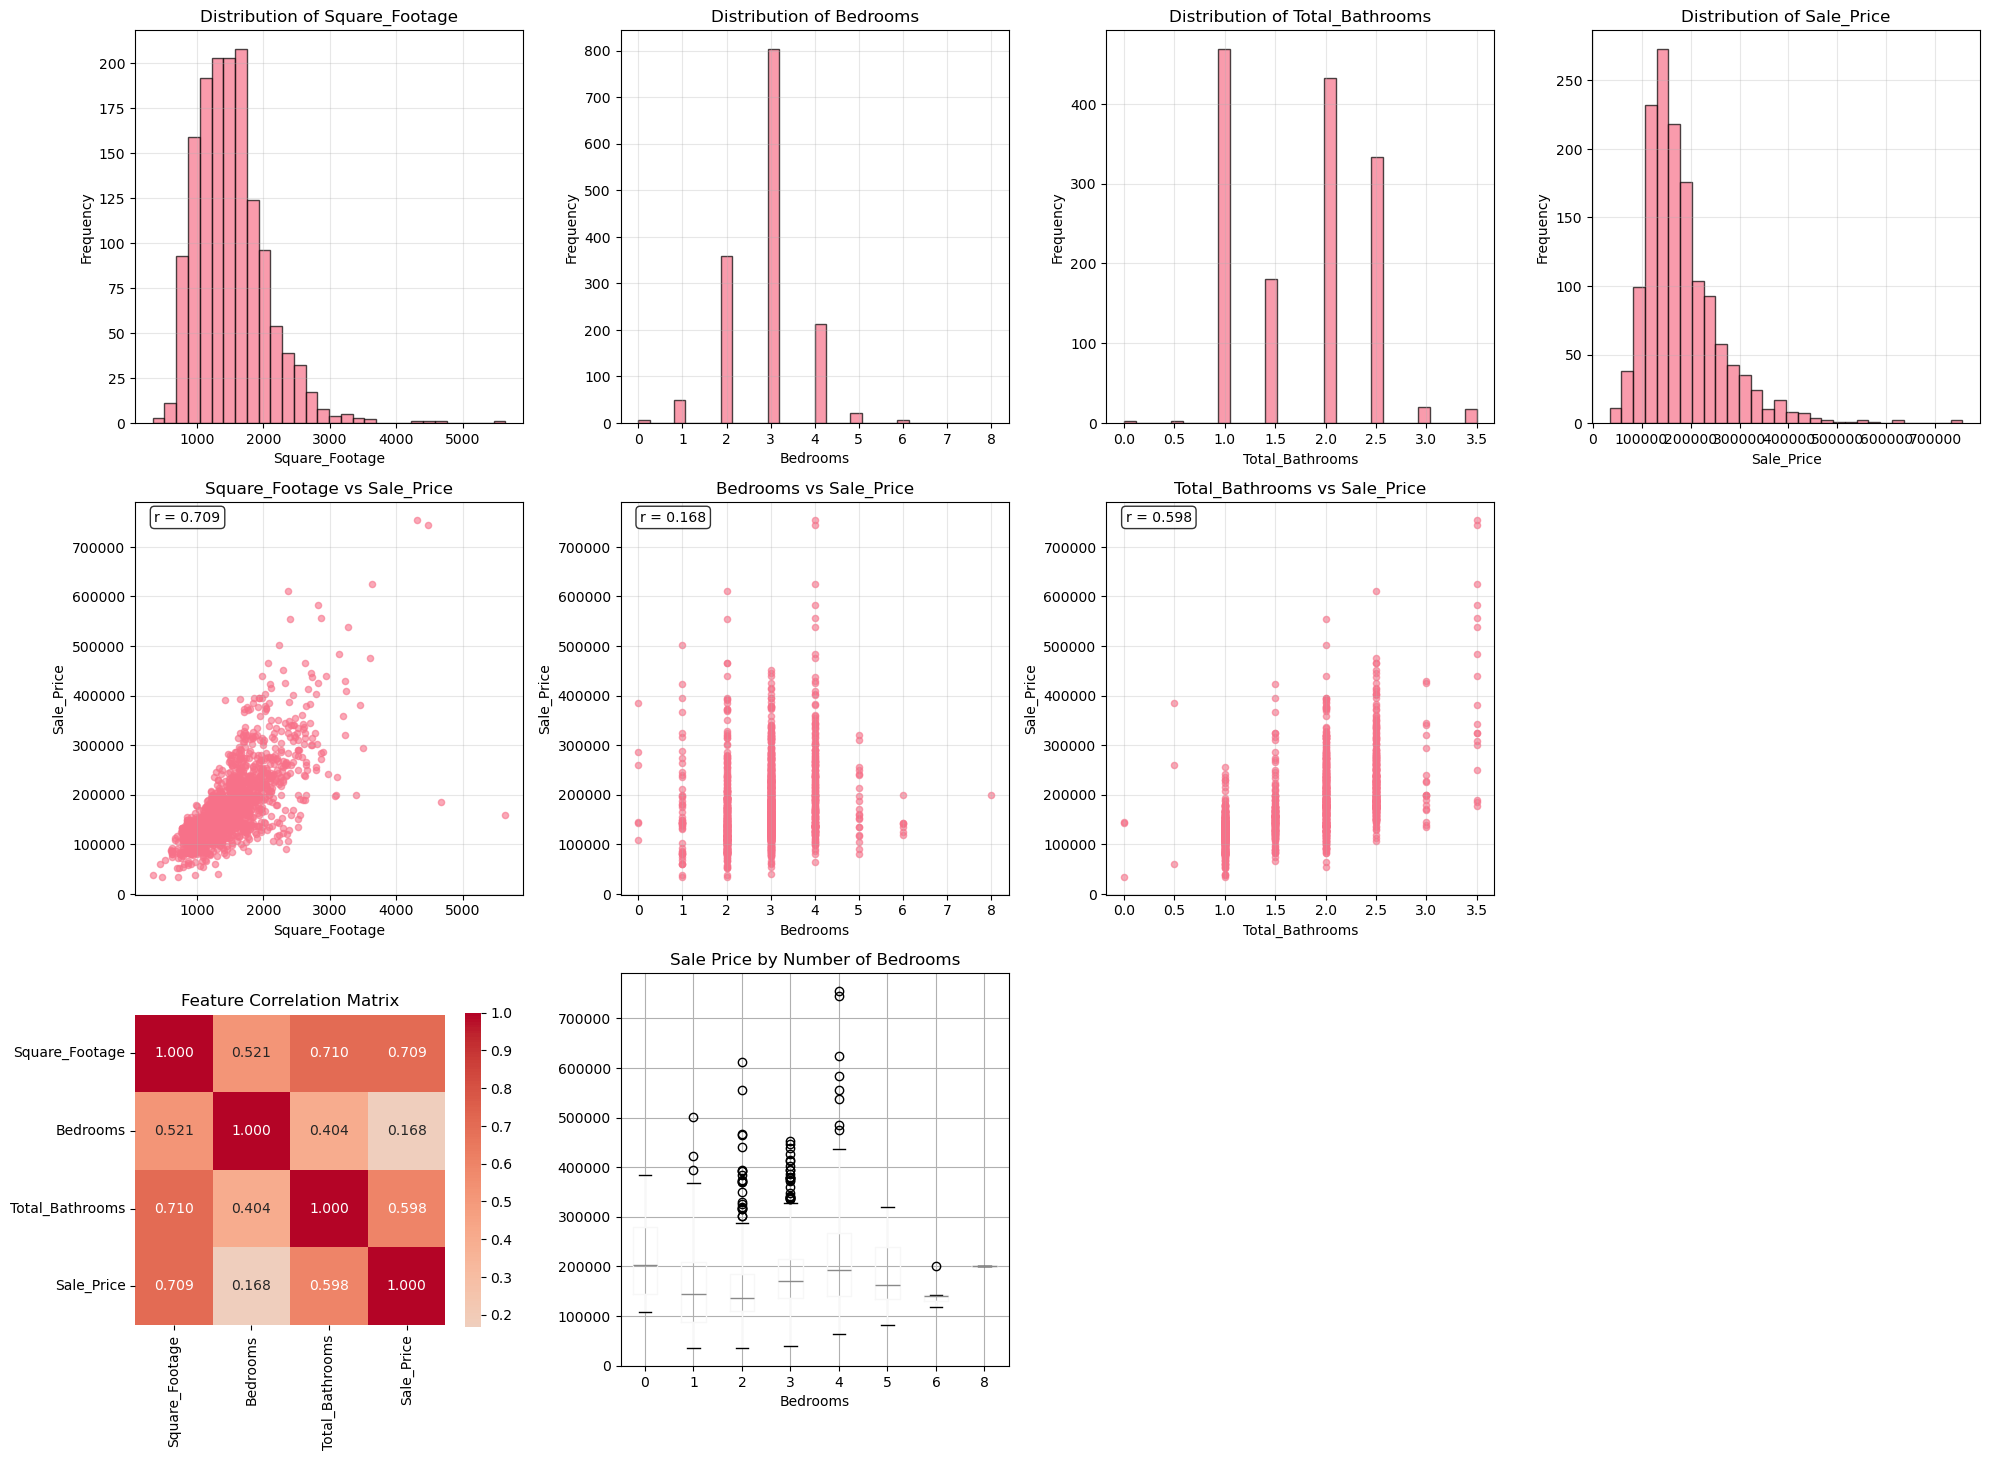

In [20]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print("📊 Descriptive Statistics:")
print(clean_data.describe().round(2))

# Check for outliers using IQR method
print("\n🎯 Outlier Detection (IQR Method):")
for col in final_features + [target]:
    Q1 = clean_data[col].quantile(0.25)
    Q3 = clean_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((clean_data[col] < lower_bound) | (clean_data[col] > upper_bound)).sum()
    print(f"  {col}: {outliers} outliers ({(outliers/len(clean_data))*100:.1f}%)")

# Visualize distributions and relationships
plt.figure(figsize=(20, 15))

# 1. Distribution plots
for i, col in enumerate(final_features + [target], 1):
    plt.subplot(3, 4, i)
    plt.hist(clean_data[col], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# 2. Feature relationships with target
for i, feature in enumerate(final_features, 1):
    plt.subplot(3, 4, i + 4)
    plt.scatter(clean_data[feature], clean_data[target], alpha=0.6, s=20)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'{feature} vs {target}')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = clean_data[feature].corr(clean_data[target])
    plt.text(0.05, 0.95, f'r = {corr:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Correlation heatmap
plt.subplot(3, 4, 9)
corr_matrix = clean_data[final_features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')

# 4. Boxplot for categorical features
plt.subplot(3, 4, 10)
clean_data.boxplot(column=target, by='Bedrooms', ax=plt.gca())
plt.title('Sale Price by Number of Bedrooms')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

In [21]:
print("\n" + "="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)

# Separate features and target
X = clean_data[final_features].copy()
y = clean_data[target].copy()

print(f"📐 Feature Matrix Shape: {X.shape}")
print(f"📐 Target Vector Shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 Data Split:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Display feature statistics for each set
print(f"\n📈 Training Set Statistics:")
print(X_train.describe().round(2))



PREPARING DATA FOR MODELING
📐 Feature Matrix Shape: (1460, 3)
📐 Target Vector Shape: (1460,)

📊 Data Split:
  Training set: 1,168 samples (80.0%)
  Test set: 292 samples (20.0%)

📈 Training Set Statistics:
       Square_Footage  Bedrooms  Total_Bathrooms
count         1168.00   1168.00          1168.00
mean          1527.40      2.89             1.77
std            524.43      0.80             0.63
min            334.00      0.00             0.00
25%           1145.75      2.00             1.00
50%           1473.00      3.00             2.00
75%           1792.00      3.00             2.50
max           5642.00      8.00             3.50


In [22]:
print("\n" + "="*80)
print("LINEAR REGRESSION MODEL TRAINING")
print("="*80)

# Create and train the model
model = LinearRegression()
print("🔧 Training linear regression model...")
model.fit(X_train, y_train)
print("✓ Model training completed!")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("✓ Predictions generated for training and test sets")



LINEAR REGRESSION MODEL TRAINING
🔧 Training linear regression model...
✓ Model training completed!
✓ Predictions generated for training and test sets


In [23]:
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Calculate comprehensive metrics
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and return evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate mean percentage error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

# Evaluate on both sets
train_metrics = evaluate_model(y_train, y_train_pred, 'Training')
test_metrics = evaluate_model(y_test, y_test_pred, 'Test')

# Display results
print("📊 Model Performance Metrics:")
print(f"{'Metric':<12} {'Training':<15} {'Test':<15} {'Difference':<12}")
print("-" * 60)

metrics_to_show = ['R²', 'RMSE', 'MAE', 'MAPE']
for metric in metrics_to_show:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = abs(train_val - test_val)
    
    if metric == 'R²':
        print(f"{metric:<12} {train_val:<15.4f} {test_val:<15.4f} {diff:<12.4f}")
    elif metric == 'MAPE':
        print(f"{metric:<12} {train_val:<15.2f}% {test_val:<15.2f}% {diff:<12.2f}%")
    else:
        print(f"{metric:<12} ${train_val:<14,.0f} ${test_val:<14,.0f} ${diff:<11,.0f}")



MODEL EVALUATION
📊 Model Performance Metrics:
Metric       Training        Test            Difference  
------------------------------------------------------------
R²           0.5623          0.6286          0.0663      
RMSE         $51,093         $53,372         $2,279      
MAE          $35,269         $36,570         $1,301      
MAPE         21.50          % 22.96          % 1.46        %


In [24]:
print("\n" + "="*80)
print("MODEL INTERPRETATION")
print("="*80)

# Display coefficients
print("🔍 Model Coefficients:")
print(f"  Intercept: ${model.intercept_:,.2f}")
for feature, coef in zip(final_features, model.coef_):
    print(f"  {feature}: ${coef:,.2f}")

# Model equation
print(f"\n📐 Linear Regression Equation:")
equation = f"Sale_Price = ${model.intercept_:,.0f}"
for feature, coef in zip(final_features, model.coef_):
    sign = "+" if coef >= 0 else ""
    equation += f" {sign} {coef:,.2f} × {feature}"
print(f"  {equation}")

# Interpretation
print(f"\n💡 Coefficient Interpretations:")
interpretations = [
    ("Square_Footage", "Each additional square foot increases price by", model.coef_[0]),
    ("Bedrooms", "Each additional bedroom increases price by", model.coef_[1]),
    ("Total_Bathrooms", "Each additional bathroom increases price by", model.coef_[2])
]

for feature, description, coef in interpretations:
    print(f"  • {description} ${coef:,.2f}")

print(f"\n📈 Model Performance Summary:")
print(f"  • R² Score: {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.1f}% of variance explained)")
print(f"  • Average prediction error: ${test_metrics['MAE']:,.0f}")
print(f"  • Typical prediction error: ${test_metrics['RMSE']:,.0f}")
print(f"  • Mean percentage error: {test_metrics['MAPE']:.1f}%")


MODEL INTERPRETATION
🔍 Model Coefficients:
  Intercept: $56,862.58
  Square_Footage: $100.64
  Bedrooms: $-26,645.53
  Total_Bathrooms: $27,083.21

📐 Linear Regression Equation:
  Sale_Price = $56,863 + 100.64 × Square_Footage  -26,645.53 × Bedrooms + 27,083.21 × Total_Bathrooms

💡 Coefficient Interpretations:
  • Each additional square foot increases price by $100.64
  • Each additional bedroom increases price by $-26,645.53
  • Each additional bathroom increases price by $27,083.21

📈 Model Performance Summary:
  • R² Score: 0.6286 (62.9% of variance explained)
  • Average prediction error: $36,570
  • Typical prediction error: $53,372
  • Mean percentage error: 23.0%



CREATING MODEL VISUALIZATIONS


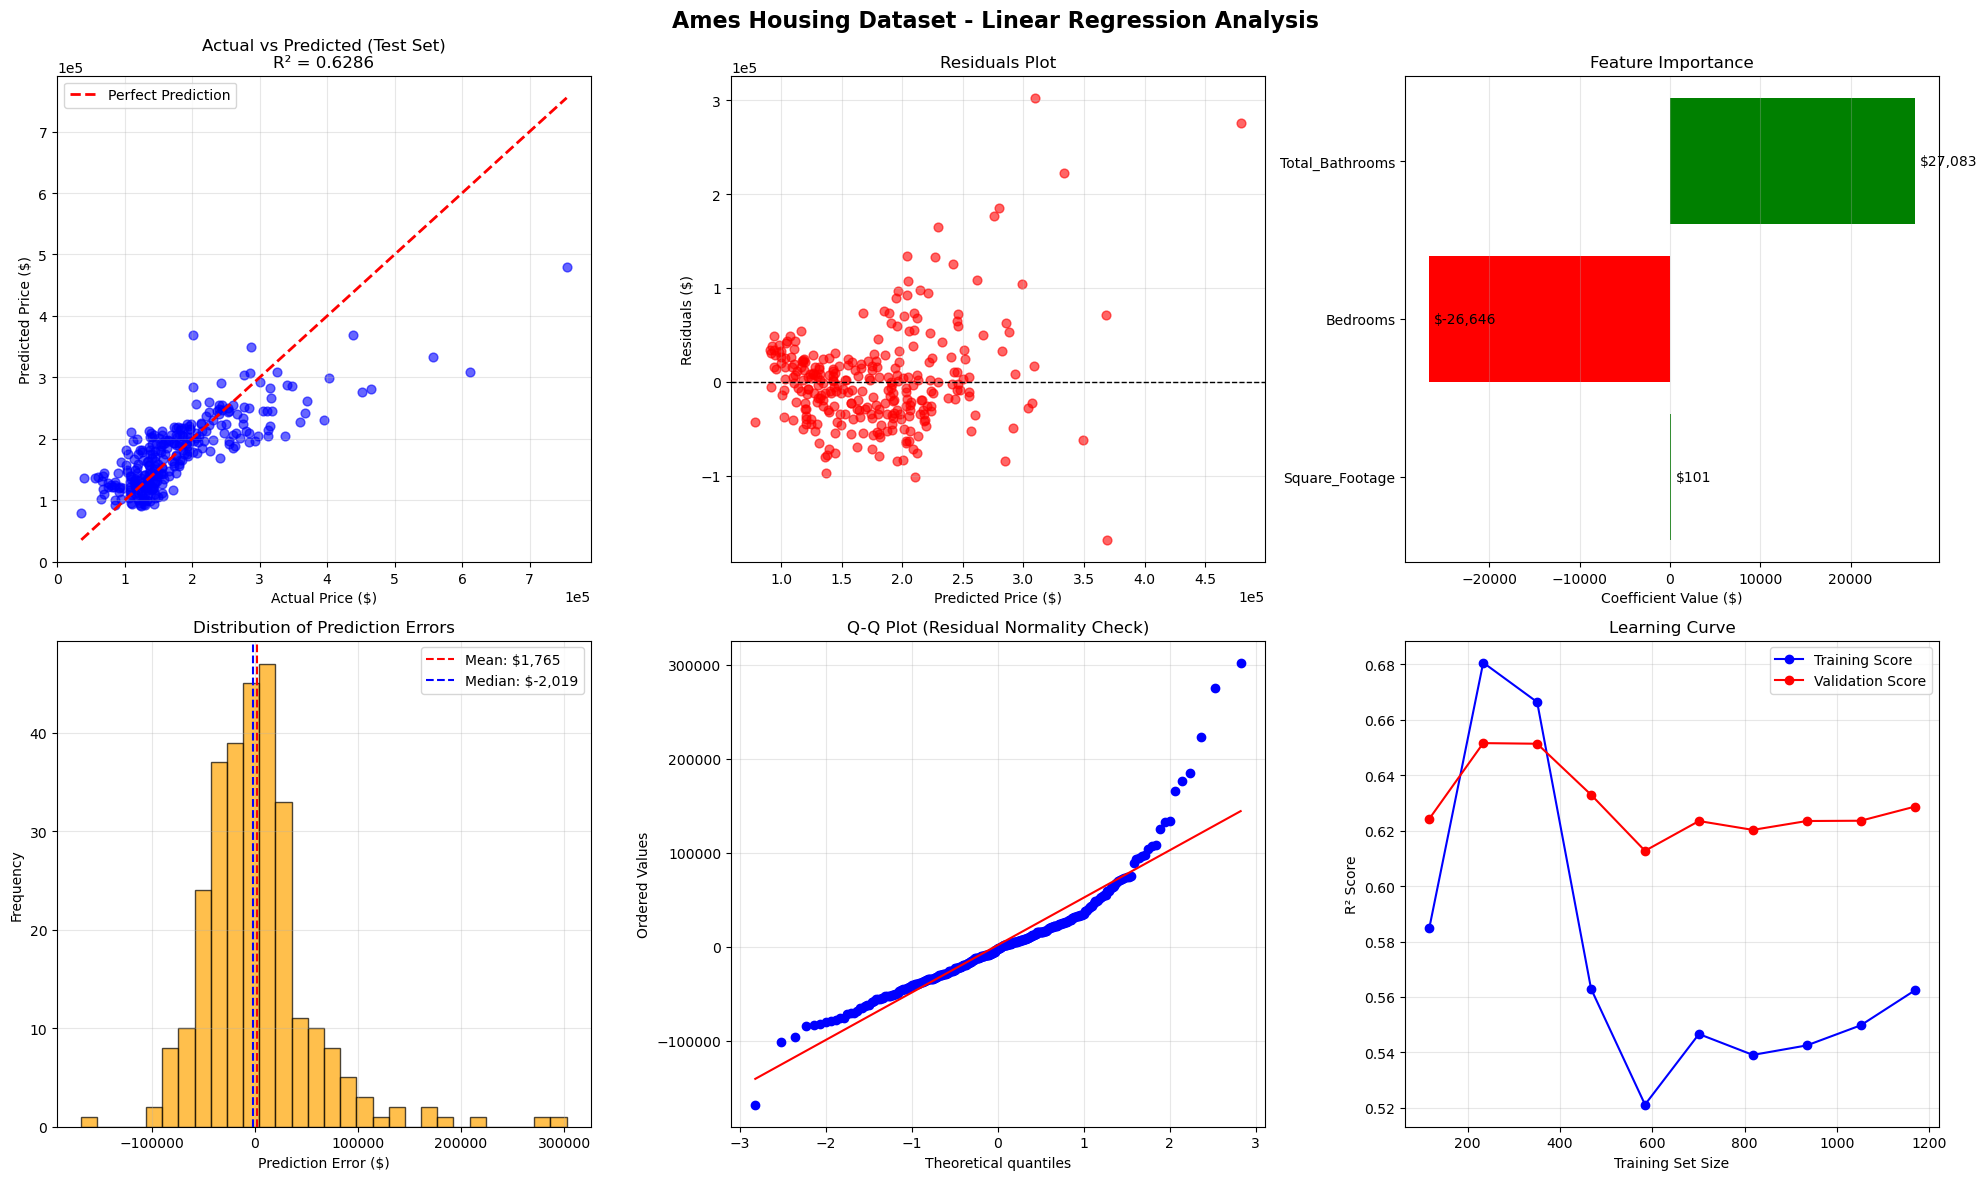

In [25]:
print("\n" + "="*80)
print("CREATING MODEL VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Ames Housing Dataset - Linear Regression Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=40)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)')
axes[0, 0].set_ylabel('Predicted Price ($)')
axes[0, 0].set_title(f'Actual vs Predicted (Test Set)\nR² = {test_metrics["R²"]:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

# 2. Residuals Plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color='red', s=40)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Predicted Price ($)')
axes[0, 1].set_ylabel('Residuals ($)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

# 3. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': final_features,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=True)

colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
bars = axes[0, 2].barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
axes[0, 2].set_xlabel('Coefficient Value ($)')
axes[0, 2].set_title('Feature Importance')
axes[0, 2].grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, value in zip(bars, feature_importance['Coefficient']):
    width = bar.get_width()
    axes[0, 2].text(width + (max(feature_importance['Coefficient']) * 0.02), 
                    bar.get_y() + bar.get_height()/2, 
                    f'${value:,.0f}', ha='left', va='center')

# 4. Prediction Error Distribution
axes[1, 0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', 
                   label=f'Mean: ${residuals.mean():,.0f}')
axes[1, 0].axvline(residuals.median(), color='blue', linestyle='--', 
                   label=f'Median: ${residuals.median():,.0f}')
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Q-Q Plot for residual normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Residual Normality Check)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Learning Curve (Training vs Validation)
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

for size in train_sizes:
    # Sample training data
    sample_size = int(size * len(X_train))
    X_sample = X_train.iloc[:sample_size]
    y_sample = y_train.iloc[:sample_size]
    
    # Train model
    temp_model = LinearRegression()
    temp_model.fit(X_sample, y_sample)
    
    # Evaluate
    train_pred = temp_model.predict(X_sample)
    val_pred = temp_model.predict(X_test)
    
    train_scores.append(r2_score(y_sample, train_pred))
    val_scores.append(r2_score(y_test, val_pred))

axes[1, 2].plot(train_sizes * len(X_train), train_scores, 'o-', color='blue', label='Training Score')
axes[1, 2].plot(train_sizes * len(X_train), val_scores, 'o-', color='red', label='Validation Score')
axes[1, 2].set_xlabel('Training Set Size')
axes[1, 2].set_ylabel('R² Score')
axes[1, 2].set_title('Learning Curve')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print("\n" + "="*80)
print("HOUSE PRICE PREDICTION FUNCTION")
print("="*80)

def predict_house_price(square_footage, bedrooms, total_bathrooms, show_details=True):
    """
    Predict house price based on square footage, bedrooms, and bathrooms
    
    Parameters:
    -----------
    square_footage : int/float
        Above grade living area in square feet
    bedrooms : int/float  
        Number of bedrooms above grade
    total_bathrooms : float
        Total bathrooms (full + half*0.5)
    show_details : bool
        Whether to show calculation details
    
    Returns:
    --------
    float : Predicted house price in dollars
    """
    
    # Make prediction
    features = np.array([[square_footage, bedrooms, total_bathrooms]])
    prediction = model.predict(features)[0]
    
    if show_details:
        print(f"\n🏠 House Price Prediction:")
        print(f"   Square Footage: {square_footage:,} sq ft")
        print(f"   Bedrooms: {bedrooms}")
        print(f"   Total Bathrooms: {total_bathrooms}")
        print(f"   ✨ Predicted Price: ${prediction:,.2f}")
        
        # Show contribution breakdown
        print(f"\n📊 Price Breakdown:")
        print(f"   Base Price: ${model.intercept_:,.2f}")
        
        contributions = []
        for i, (feature, coef) in enumerate(zip(final_features, model.coef_)):
            feature_value = features[0][i]
            contribution = coef * feature_value
            contributions.append(contribution)
            print(f"   {feature}: ${coef:,.2f} × {feature_value} = ${contribution:,.2f}")
        
        total_contribution = sum(contributions) + model.intercept_
        print(f"   {'='*50}")
        print(f"   Total: ${total_contribution:,.2f}")
    
    return prediction

# Example predictions
print("🎯 Example House Price Predictions:")
print("="*60)

examples = [
    (1000, 2, 1.0, "Small starter home"),
    (1500, 3, 2.0, "Average family home"),  
    (2000, 3, 2.5, "Comfortable family home"),
    (2500, 4, 3.0, "Spacious family home"),
    (3000, 4, 3.5, "Large family home"),
    (4000, 5, 4.0, "Luxury home")
]

results = []
for sqft, beds, baths, description in examples:
    price = predict_house_price(sqft, beds, baths, show_details=False)
    results.append({
        'Description': description,
        'SqFt': sqft,
        'Bedrooms': beds, 
        'Bathrooms': baths,
        'Predicted_Price': price
    })

# Display in a nice table format
results_df = pd.DataFrame(results)
results_df['Price_per_SqFt'] = results_df['Predicted_Price'] / results_df['SqFt']

print(f"{'Description':<25} {'SqFt':<6} {'Bed':<4} {'Bath':<5} {'Price':<12} {'$/SqFt':<8}")
print("-" * 70)
for _, row in results_df.iterrows():
    print(f"{row['Description']:<25} {row['SqFt']:<6} {row['Bedrooms']:<4} "
          f"{row['Bathrooms']:<5} ${row['Predicted_Price']:<11,.0f} ${row['Price_per_SqFt']:<7.0f}")


HOUSE PRICE PREDICTION FUNCTION
🎯 Example House Price Predictions:
Description               SqFt   Bed  Bath  Price        $/SqFt  
----------------------------------------------------------------------
Small starter home        1000   2    1.0   $131,292     $131    
Average family home       1500   3    2.0   $182,048     $121    
Comfortable family home   2000   3    2.5   $245,908     $123    
Spacious family home      2500   4    3.0   $283,122     $113    
Large family home         3000   4    3.5   $346,982     $116    
Luxury home               4000   5    4.0   $434,515     $109    


In [28]:
print("\n" + "="*80)
print("MODEL VALIDATION AND ASSUMPTIONS")
print("="*80)

# Check linear regression assumptions
print("🔍 Linear Regression Assumptions Check:")

# 1. Linearity - correlation check
print("\n1. Linearity Check (Feature-Target Correlations):")
for feature in final_features:
    corr = clean_data[feature].corr(clean_data[target])
    print(f"   {feature}: r = {corr:.4f}")

# 2. Independence - DW test would be ideal, but we'll check autocorrelation
print(f"\n2. Independence Check:")
print(f"   Residual autocorrelation: {np.corrcoef(residuals[:-1], residuals[1:])[0,1]:.4f}")

# 3. Homoscedasticity - Breusch-Pagan test approximation
print(f"\n3. Homoscedasticity Check:")
# Simple check: correlation between predicted values and absolute residuals
abs_residuals = np.abs(residuals)
homoscedasticity_corr = np.corrcoef(y_test_pred, abs_residuals)[0,1]
print(f"   Correlation between predictions and |residuals|: {homoscedasticity_corr:.4f}")
print(f"   (Values close to 0 indicate homoscedasticity)")

# 4. Normality of residuals
from scipy.stats import shapiro, jarque_bera
print(f"\n4. Normality of Residuals:")
shapiro_stat, shapiro_p = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
jb_stat, jb_p = jarque_bera(residuals)
print(f"   Shapiro-Wilk test p-value: {shapiro_p:.6f}")
print(f"   Jarque-Bera test p-value: {jb_p:.6f}")
print(f"   (p > 0.05 suggests residuals are normally distributed)")

# 5. Multicollinearity check
print(f"\n5. Multicollinearity Check (VIF approximation):")
corr_matrix = X.corr()
print("   Feature correlations:")
for i in range(len(final_features)):
    for j in range(i+1, len(final_features)):
        corr_val = corr_matrix.iloc[i,j]
        print(f"   {final_features[i]} vs {final_features[j]}: {corr_val:.4f}")


MODEL VALIDATION AND ASSUMPTIONS
🔍 Linear Regression Assumptions Check:

1. Linearity Check (Feature-Target Correlations):
   Square_Footage: r = 0.7086
   Bedrooms: r = 0.1682
   Total_Bathrooms: r = 0.5980

2. Independence Check:
   Residual autocorrelation: 0.0405

3. Homoscedasticity Check:
   Correlation between predictions and |residuals|: 0.4652
   (Values close to 0 indicate homoscedasticity)

4. Normality of Residuals:
   Shapiro-Wilk test p-value: 0.000000
   Jarque-Bera test p-value: 0.000000
   (p > 0.05 suggests residuals are normally distributed)

5. Multicollinearity Check (VIF approximation):
   Feature correlations:
   Square_Footage vs Bedrooms: 0.5213
   Square_Footage vs Total_Bathrooms: 0.7101
   Bedrooms vs Total_Bathrooms: 0.4043


In [33]:
print("\n" + "="*80)
print("INTERACTIVE PREDICTION TOOL")
print("="*80)

def interactive_prediction():
    """Interactive tool for making house price predictions"""
    print("🏡 Welcome to the House Price Predictor!")
    print("Enter the house characteristics to get a price prediction.")
    print("(Press Enter with empty input to exit)")
    
    while True:
        try:
            print("\n" + "-"*50)
            sqft_input = input("Enter square footage (e.g., 2000): ").strip()
            if not sqft_input:
                break
            sqft = float(sqft_input)
            
            bed_input = input("Enter number of bedrooms (e.g., 3): ").strip()
            if not bed_input:
                break
            bedrooms = int(bed_input)
            
            bath_input = input("Enter total bathrooms (e.g., 2.5): ").strip()
            if not bath_input:
                break
            bathrooms = float(bath_input)
            
            # Make prediction
            predicted_price = predict_house_price(sqft, bedrooms, bathrooms, show_details=True)
            
            # Additional context
            mean_price = clean_data[target].mean()
            median_price = clean_data[target].median()
            
            print(f"\n📈 Market Context:")
            print(f"   Average house price in dataset: ${mean_price:,.0f}")
            print(f"   Median house price in dataset: ${median_price:,.0f}")
            
            if predicted_price > mean_price:
                print(f"   This house is predicted to be {((predicted_price/mean_price-1)*100):+.1f}% above average")
            else:
                print(f"   This house is predicted to be {((predicted_price/mean_price-1)*100):+.1f}% below average")
                
        except ValueError:
            print("❌ Please enter valid numbers!")
        except KeyboardInterrupt:
            break
    
    print("\n👋 Thanks for using the House Price Predictor!")

# Uncomment the line below to run the interactive tool
interactive_prediction()


INTERACTIVE PREDICTION TOOL
🏡 Welcome to the House Price Predictor!
Enter the house characteristics to get a price prediction.
(Press Enter with empty input to exit)

--------------------------------------------------


Enter square footage (e.g., 2000):  1500
Enter number of bedrooms (e.g., 3):  3
Enter total bathrooms (e.g., 2.5):  5



🏠 House Price Prediction:
   Square Footage: 1,500.0 sq ft
   Bedrooms: 3
   Total Bathrooms: 5.0
   ✨ Predicted Price: $263,297.36

📊 Price Breakdown:
   Base Price: $56,862.58
   Square_Footage: $100.64 × 1500.0 = $150,955.34
   Bedrooms: $-26,645.53 × 3.0 = $-79,936.60
   Total_Bathrooms: $27,083.21 × 5.0 = $135,416.04
   Total: $263,297.36

📈 Market Context:
   Average house price in dataset: $180,921
   Median house price in dataset: $163,000
   This house is predicted to be +45.5% above average

--------------------------------------------------


Enter square footage (e.g., 2000):  



👋 Thanks for using the House Price Predictor!


In [34]:
print("\n" + "="*80)
print("MODEL SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("📋 Model Summary:")
print(f"   • Model Type: Linear Regression")
print(f"   • Features: {', '.join(final_features)}")
print(f"   • Training Data: {len(X_train):,} houses")
print(f"   • Test Data: {len(X_test):,} houses")
print(f"   • R² Score: {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.1f}% variance explained)")
print(f"   • RMSE: ${test_metrics['RMSE']:,.0f}")
print(f"   • MAE: ${test_metrics['MAE']:,.0f}")
print(f"   • MAPE: {test_metrics['MAPE']:.1f}%")

print(f"\n💡 Key Insights:")
print(f"   • Most important factor: {final_features[np.argmax(np.abs(model.coef_))]}")
print(f"   • Each sq ft adds: ${model.coef_[0]:.2f} to house value")
print(f"   • Each bedroom adds: ${model.coef_[1]:,.0f} to house value") 
print(f"   • Each bathroom adds: ${model.coef_[2]:,.0f} to house value")

# Model performance assessment
r2_interpretation = ""
if test_metrics['R²'] >= 0.8:
    r2_interpretation = "Excellent model performance"
elif test_metrics['R²'] >= 0.6:
    r2_interpretation = "Good model performance"  
elif test_metrics['R²'] >= 0.4:
    r2_interpretation = "Moderate model performance"
else:
    r2_interpretation = "Poor model performance"

print(f"\n🎯 Model Assessment: {r2_interpretation}")

print(f"\n🔧 Recommendations for Improvement:")
print(f"   • Consider adding more features (lot size, garage, neighborhood)")
print(f"   • Try polynomial features for non-linear relationships")
print(f"   • Consider regularization (Ridge/Lasso) to prevent overfitting")
print(f"   • Explore feature interactions (e.g., sqft × bedrooms)")
print(f"   • Handle outliers more systematically")

print(f"\n✅ Model is now ready for making house price predictions!")
print(f"   Use: predict_house_price(square_footage, bedrooms, bathrooms)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


MODEL SUMMARY AND RECOMMENDATIONS
📋 Model Summary:
   • Model Type: Linear Regression
   • Features: Square_Footage, Bedrooms, Total_Bathrooms
   • Training Data: 1,168 houses
   • Test Data: 292 houses
   • R² Score: 0.6286 (62.9% variance explained)
   • RMSE: $53,372
   • MAE: $36,570
   • MAPE: 23.0%

💡 Key Insights:
   • Most important factor: Total_Bathrooms
   • Each sq ft adds: $100.64 to house value
   • Each bedroom adds: $-26,646 to house value
   • Each bathroom adds: $27,083 to house value

🎯 Model Assessment: Good model performance

🔧 Recommendations for Improvement:
   • Consider adding more features (lot size, garage, neighborhood)
   • Try polynomial features for non-linear relationships
   • Consider regularization (Ridge/Lasso) to prevent overfitting
   • Explore feature interactions (e.g., sqft × bedrooms)
   • Handle outliers more systematically

✅ Model is now ready for making house price predictions!
   Use: predict_house_price(square_footage, bedrooms, bathroom

In [39]:
print("\n" + "="*80)
print("SAVING MODEL FOR LOCAL USAGE")
print("="*80)

import pickle
import joblib
import json
from datetime import datetime
import os

# Create a models directory if it doesn't exist
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"✓ Created directory: {models_dir}")

# Generate timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"house_price_model_{timestamp}"

print(f"🔧 Saving model as: {model_name}")



SAVING MODEL FOR LOCAL USAGE
🔧 Saving model as: house_price_model_20250726_150757


In [40]:
print("\n🚀 Method 2: Saving with Joblib (Recommended)")

# Save model using joblib (more efficient for scikit-learn models)
joblib_path = os.path.join(models_dir, f"{model_name}.joblib")
joblib.dump(model, joblib_path)
print(f"✓ Model saved as joblib: {joblib_path}")

# Save training data statistics for validation
training_stats = {
    'feature_stats': X_train.describe().to_dict(),
    'target_stats': {
        'mean': float(y_train.mean()),
        'std': float(y_train.std()),
        'min': float(y_train.min()),
        'max': float(y_train.max())
    }
}

stats_path = os.path.join(models_dir, f"{model_name}_training_stats.json")
with open(stats_path, 'w') as file:
    json.dump(training_stats, file, indent=2)
print(f"✓ Training statistics saved: {stats_path}")


🚀 Method 2: Saving with Joblib (Recommended)
✓ Model saved as joblib: saved_models\house_price_model_20250726_150757.joblib
✓ Training statistics saved: saved_models\house_price_model_20250726_150757_training_stats.json
